# Regression under additive noise assumption

Minimisation of mean square error is standard way to build regression models. This corresponds to deterministic dependence $y=f(x)$ that is slightly spoiled by additive Gaussian noise. However, nothing guarantees that the noise is additive or it is Gaussian at all. 

The minimisation of means squared error is guaranteed to reveal the true relation $y=f(x)$ if the followin conditions are satisfied:
* The model can represent the true relation $y=f(x)$.
* The assumption about additive Gaussian noise is true and individual errors are independent.   
* There is enough observations $(x_1, y_1),\ldots, (x_n, y_n)$ to cancel out random fluctuations.

It is really hard to estimate the number of samples. However, if such converge occurs then the prediction $\hat{y}(x)\approx f(x)$ and thus residuals $r_i=y_i-\hat{y}_i$ must follow normal distribution up to a small approximation error. By drawing the histogram of residuals and finding the bet fitted normal distribution we can easy check if all three assumptions are satisfied.  

In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import read_csv
from pandas import DataFrame

from scipy.stats import norm
from scipy.stats import laplace

from sklearn.linear_model import LinearRegression

from IPython.display import Math
from convenience import mdisplay

from plotnine import *
from plotnine import options as pl9_options
pl9_options.figure_size = (15, 7)

## I. Insufficiency of Ordinary Least Squares Regression 

Let us consider a regression task where we know from physical considerations that $y=\alpha x^2 +\beta$. To solve this task, we use input transformation $z=x^2$ to reduce it to linear regression task we can solve with standard methods. To complete the analysis, we analyse the distribution of residues $y_i-\hat{y}_i$ to see whether the assumption about additive Gaussian noise is satisfied:
\begin{align*}
y_i=\alpha x_i^2 +\beta + \varepsilon_i,\qquad\text{for}\qquad \varepsilon_i\sim\mathcal{N}(0,\sigma)\enspace.
\end{align*}

Regression data 
 
 
 $x^0$ 
 $x^1$ 
 $x^2$ 
 $y$ 
 
 
 
 
 1 
 0.728269 
 0.530376 
 0.512820 
 
 
 1 
 0.909930 
 0.827973 
 0.820282 
 
 
 1 
 0.380931 
 0.145108 
 0.250688 
 
 
 1 
 0.245030 
 0.060040 
 0.153003 
 
 
 1 
 0.626321 
 0.392278 
 0.156423

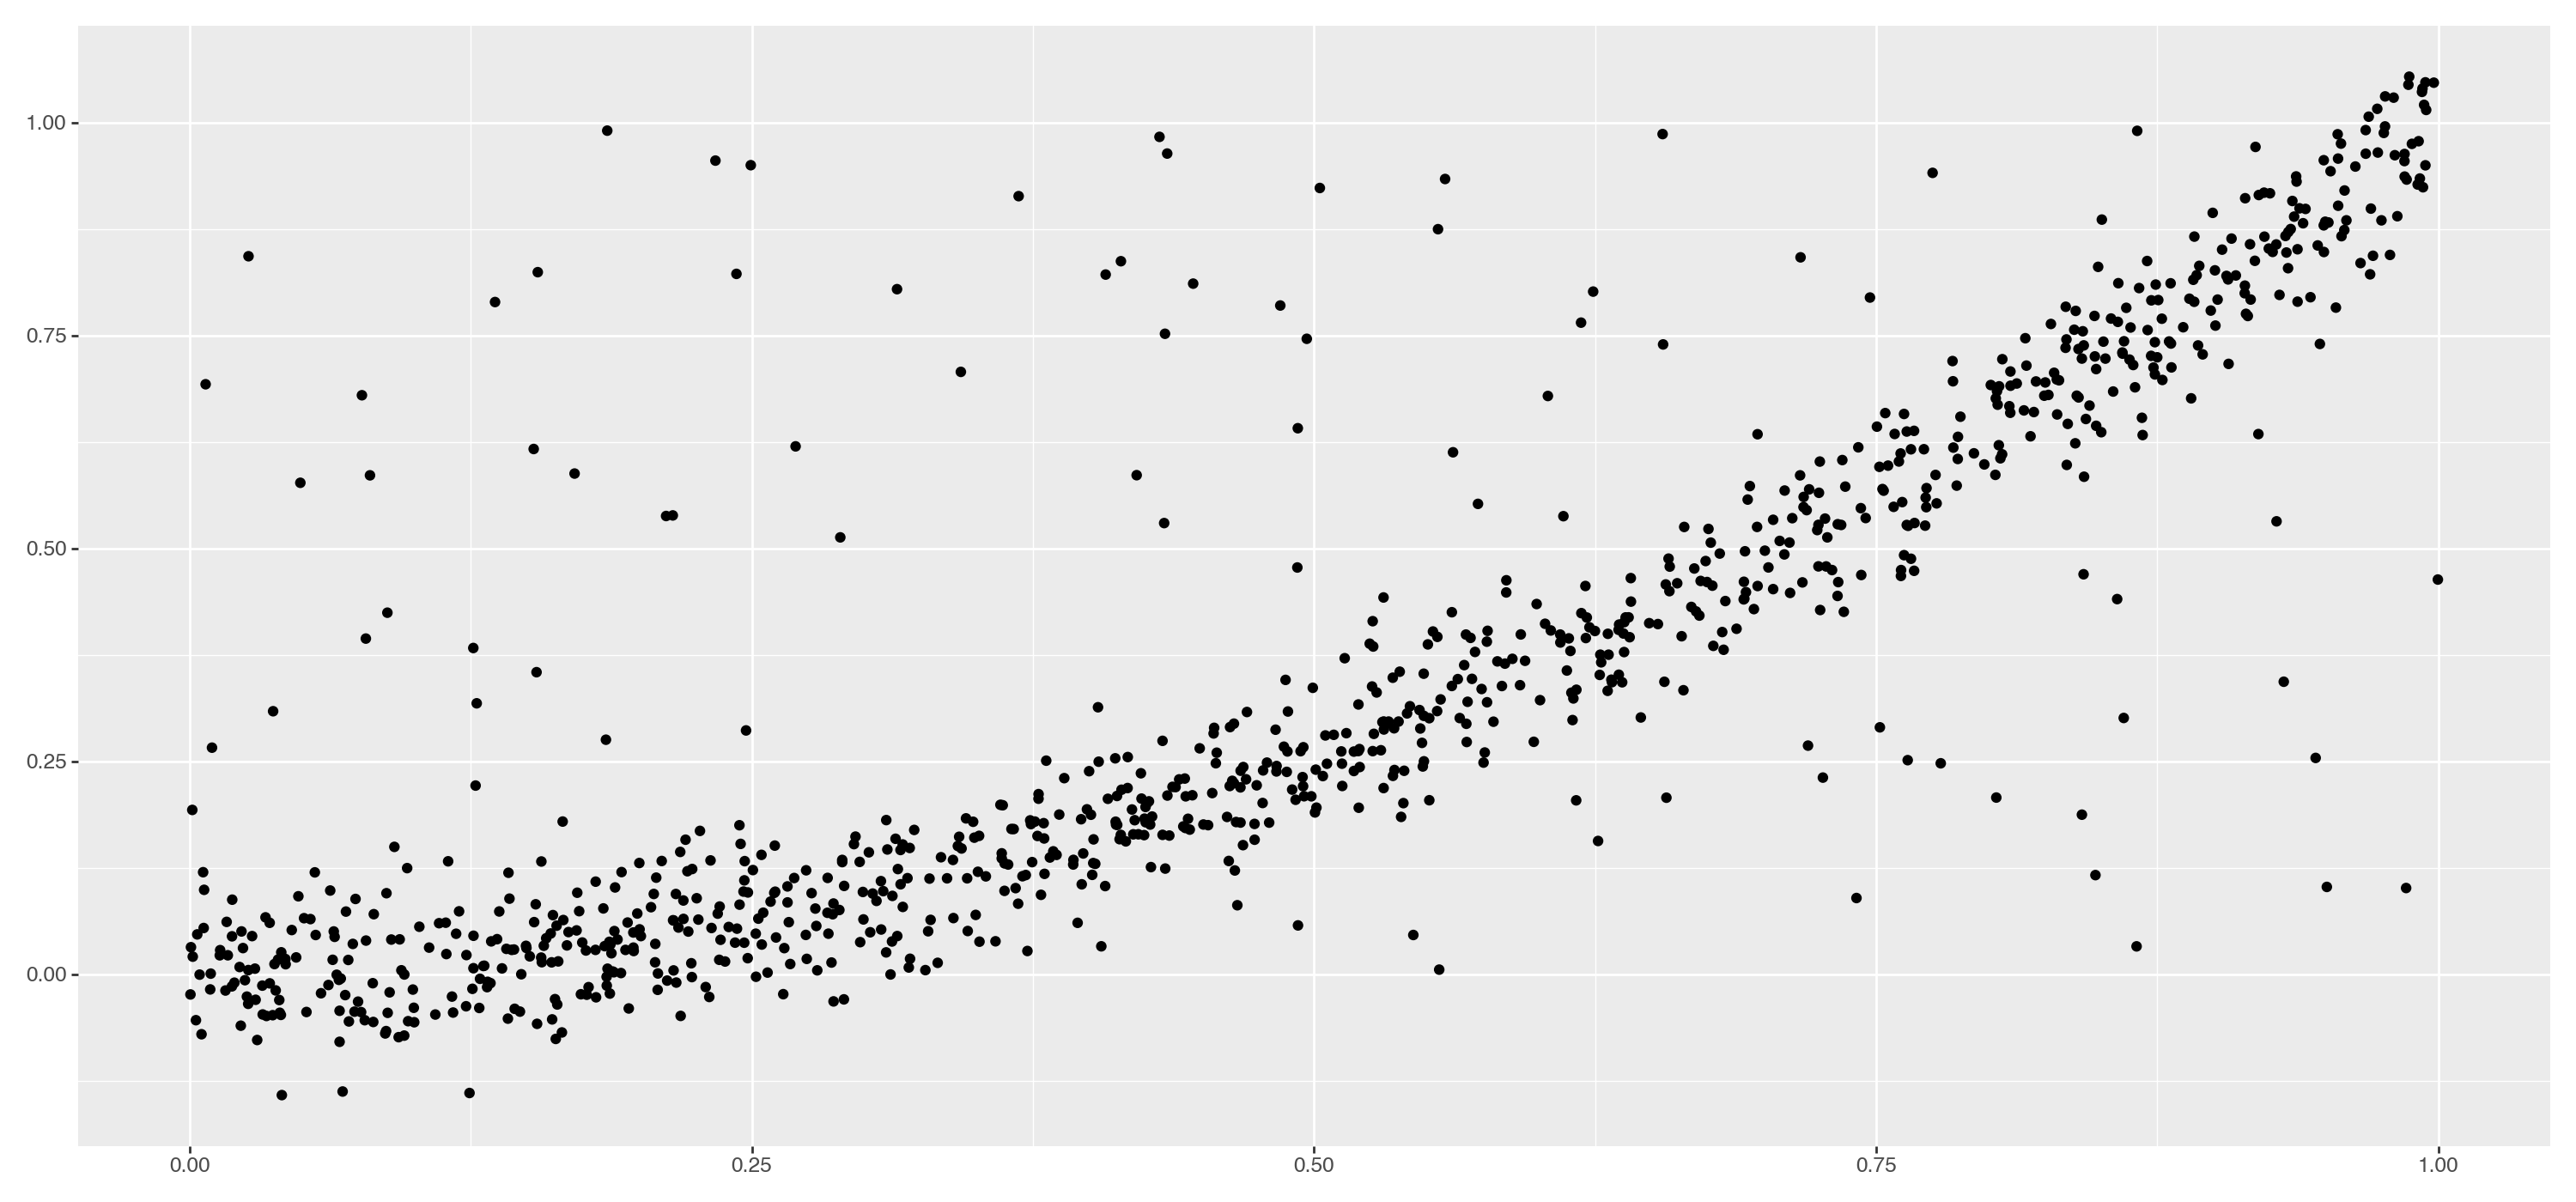

In [267]:
df = read_csv('data/regression_benchmark.csv').rename(columns={'x': '$x^1$', 'y': '$y$'})
df['$x^2$'] = df['$x^1$']**2
df['$x^0$'] = 1
df = df[['$x^0$', '$x^1$', '$x^2$', '$y$']]
mdisplay([df.head()], ['Regression data'])

p = ggplot(df) + geom_point(aes(x='$x^1$', y='$y$'))+ xlab('') + ylab('')
display(p)

# p.save('regression_challenge.pdf', path='results', height=6, width=12, verbose=False)

Let us convert this into a univariate linear regression task and solve it with ordinary least squares method.

Altered feature space 
 
 
 $x^2$ 
 $x^0$ 
 
 
 
 
 0.530376 
 1 
 
 
 0.827973 
 1 
 
 
 0.145108 
 1 
 
 
 0.060040 
 1 
 
 
 0.392278 
 1

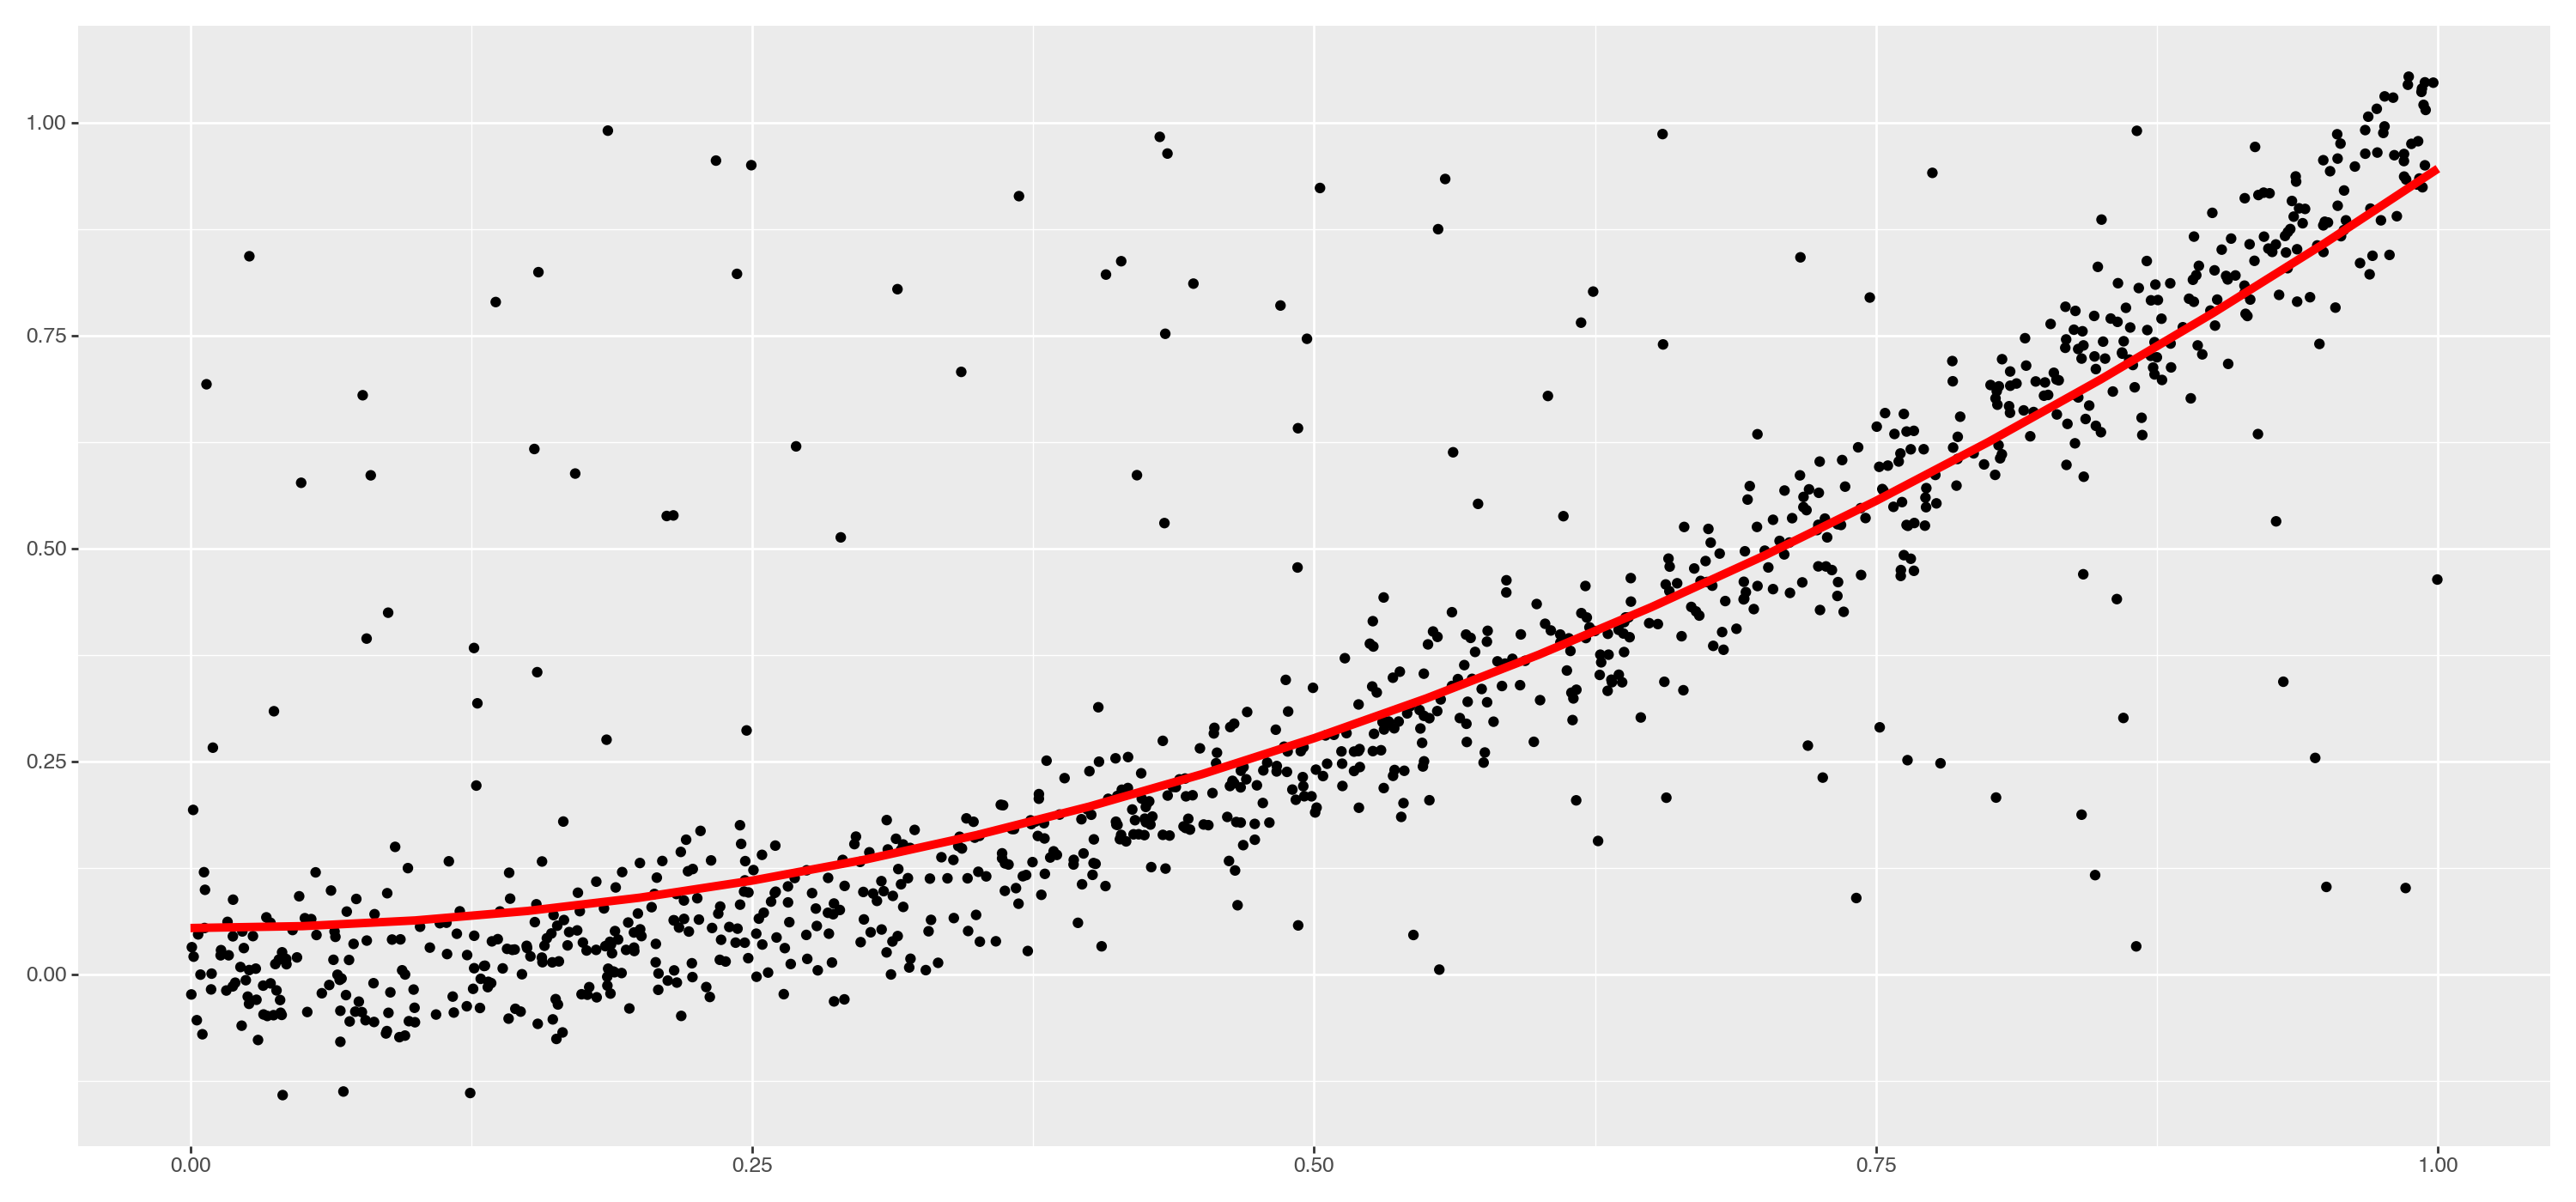

In [276]:
# Altered feature space
X = df[['$x^2$', '$x^0$']]
mdisplay([X.head()], ['Altered feature space'])

# Fit a model 
lm = LinearRegression(fit_intercept=False)
lm.fit(X, df['$y$'])
alpha, beta = lm.coef_

# Compute prediction line
dm = DataFrame({'x':arange(0, 1.05, 0.05)})
dm['y'] = alpha * dm['x']**2 + beta

# Show the corresponding graph 
p  = ggplot(df) + geom_point(aes(x='$x^1$', y='$y$'))+ xlab('') + ylab('') 
p += geom_line(aes(x='x', y='y'), data=dm, color='red', size=2)
p += labs(x="", y='')
display(p)
# p.save('naive_fit.pdf', path='results', height=6, width=12, verbose=False)

Let us now do diagnostics on residuals to see if desired assumptions really hold.

In [277]:
y_pred = lm.predict(X)
residuals = DataFrame({'residuals': df['$y$'] - y_pred})

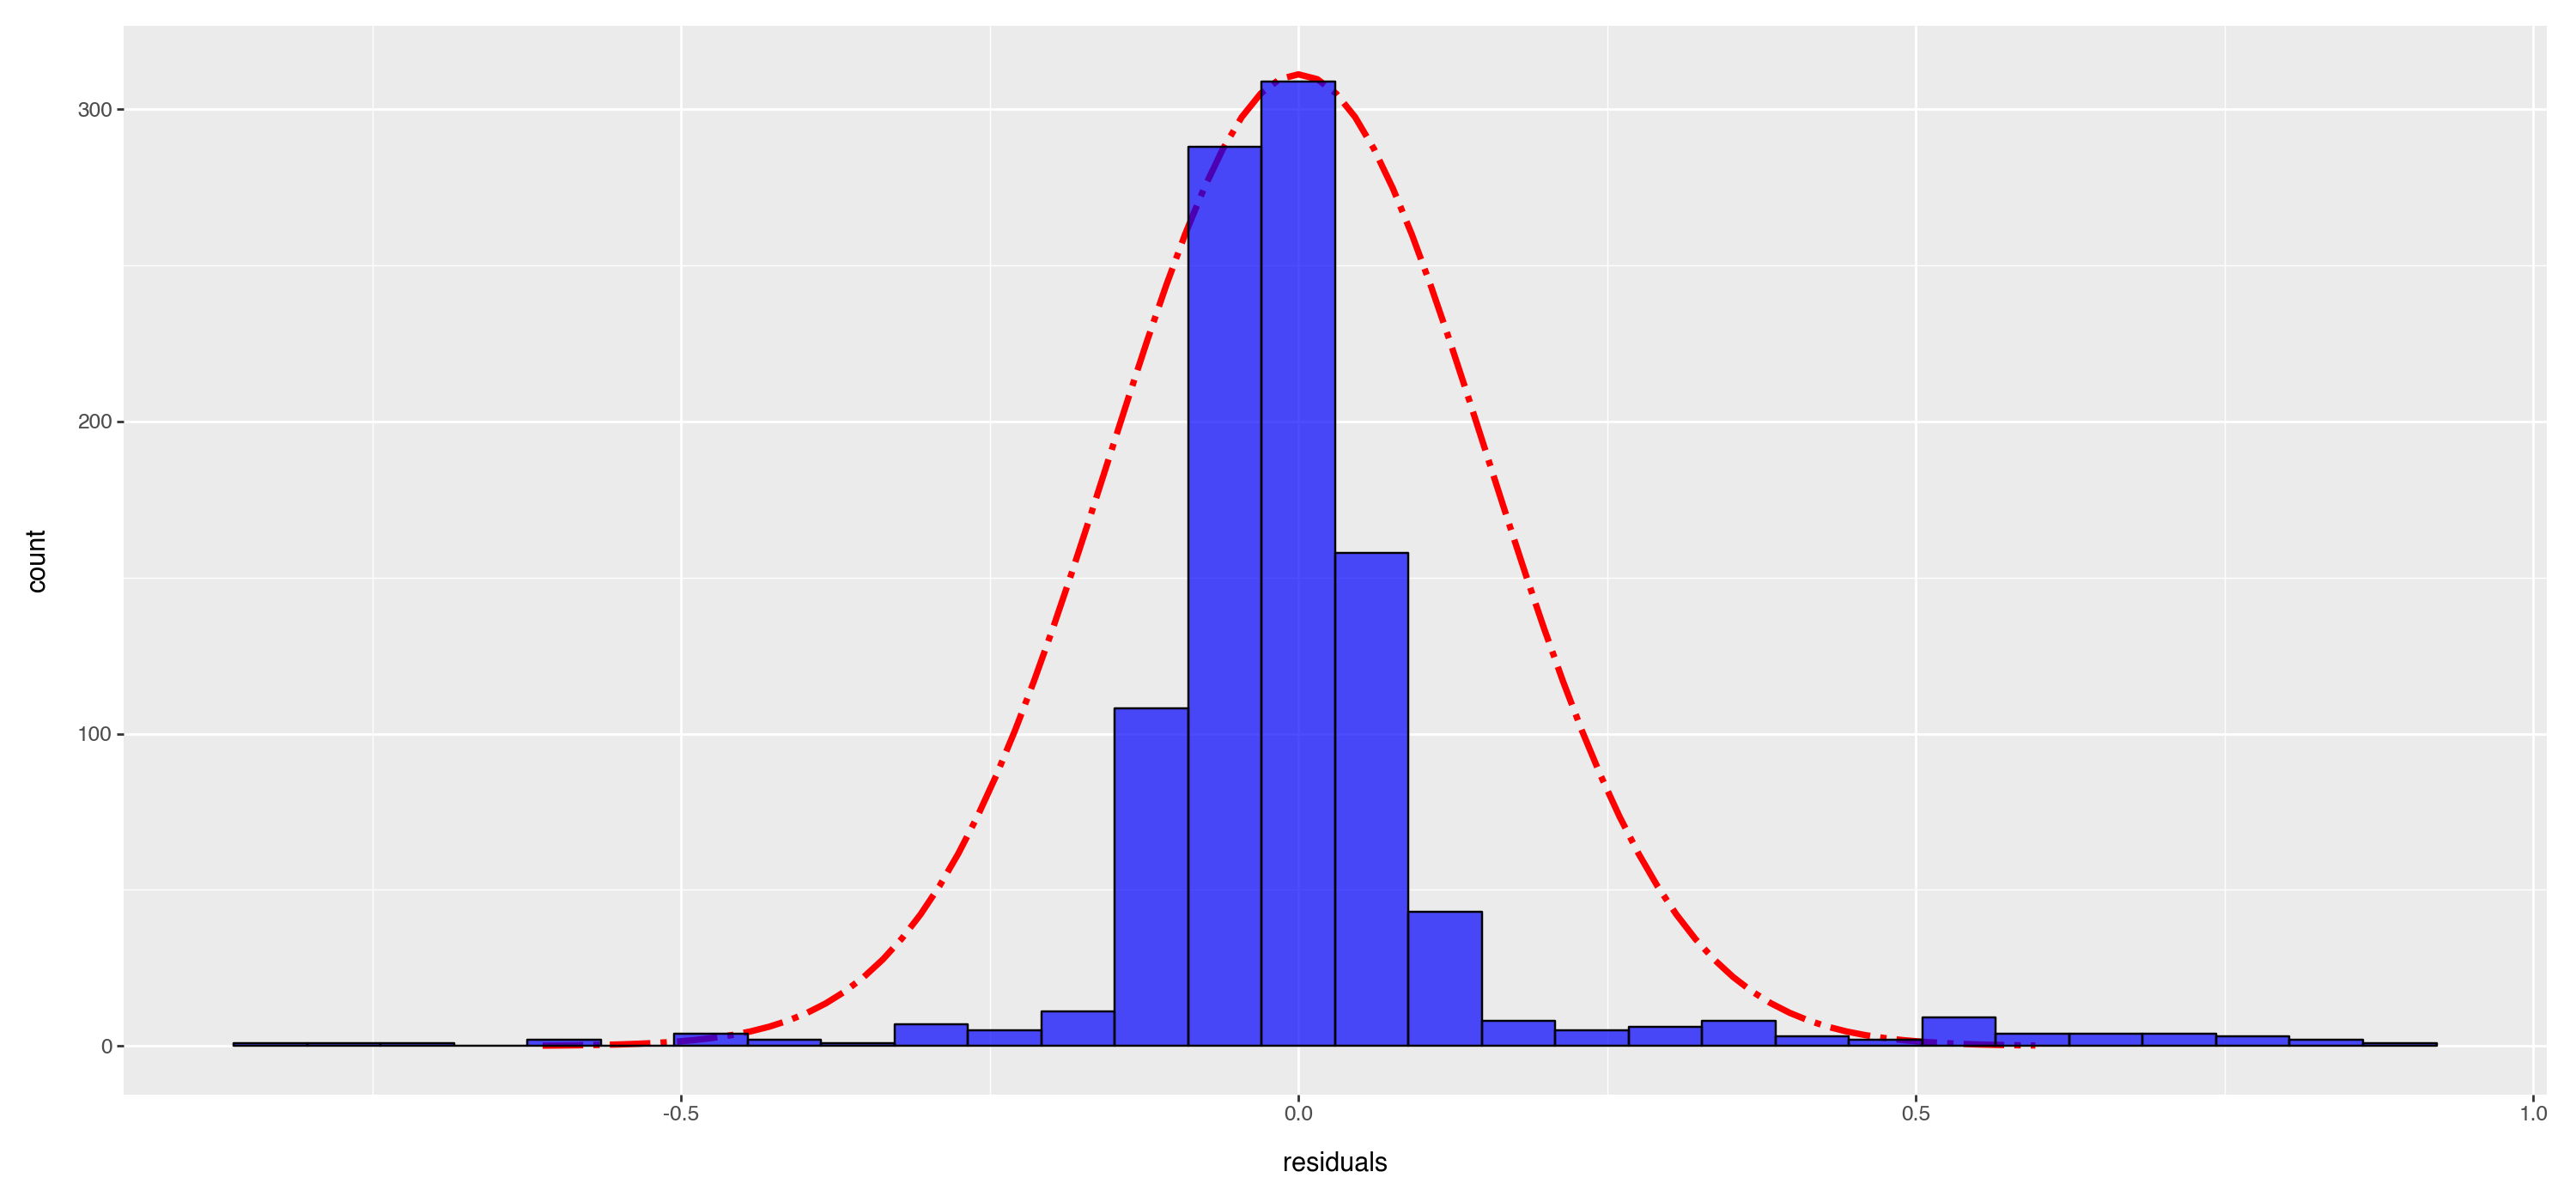

In [278]:
mu = residuals['residuals'].mean()
sigma = residuals['residuals'].std()

ndf = DataFrame({'x': arange(-4*sigma, 4*sigma, sigma/10)})
ndf['p'] = norm.pdf(ndf['x'], loc=mu, scale=sigma)
ndf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7.8 # Use Tambov constant to align graphs

p = ggplot(residuals) 
p += geom_line(aes(x='x', y='h'), data=ndf, color='red', size=1.5, linetype='dashdot')
p += geom_histogram(aes(x='residuals'), bins=30, fill="blue", color="black", alpha=0.7)
p += labs(x="residuals", y='count')
display(p)
# p.save('naive_fit_residuals.pdf', path='results', height=6, width=12, verbose=False)


Let us check if Laplace distribution as an additive error fits better on the data.

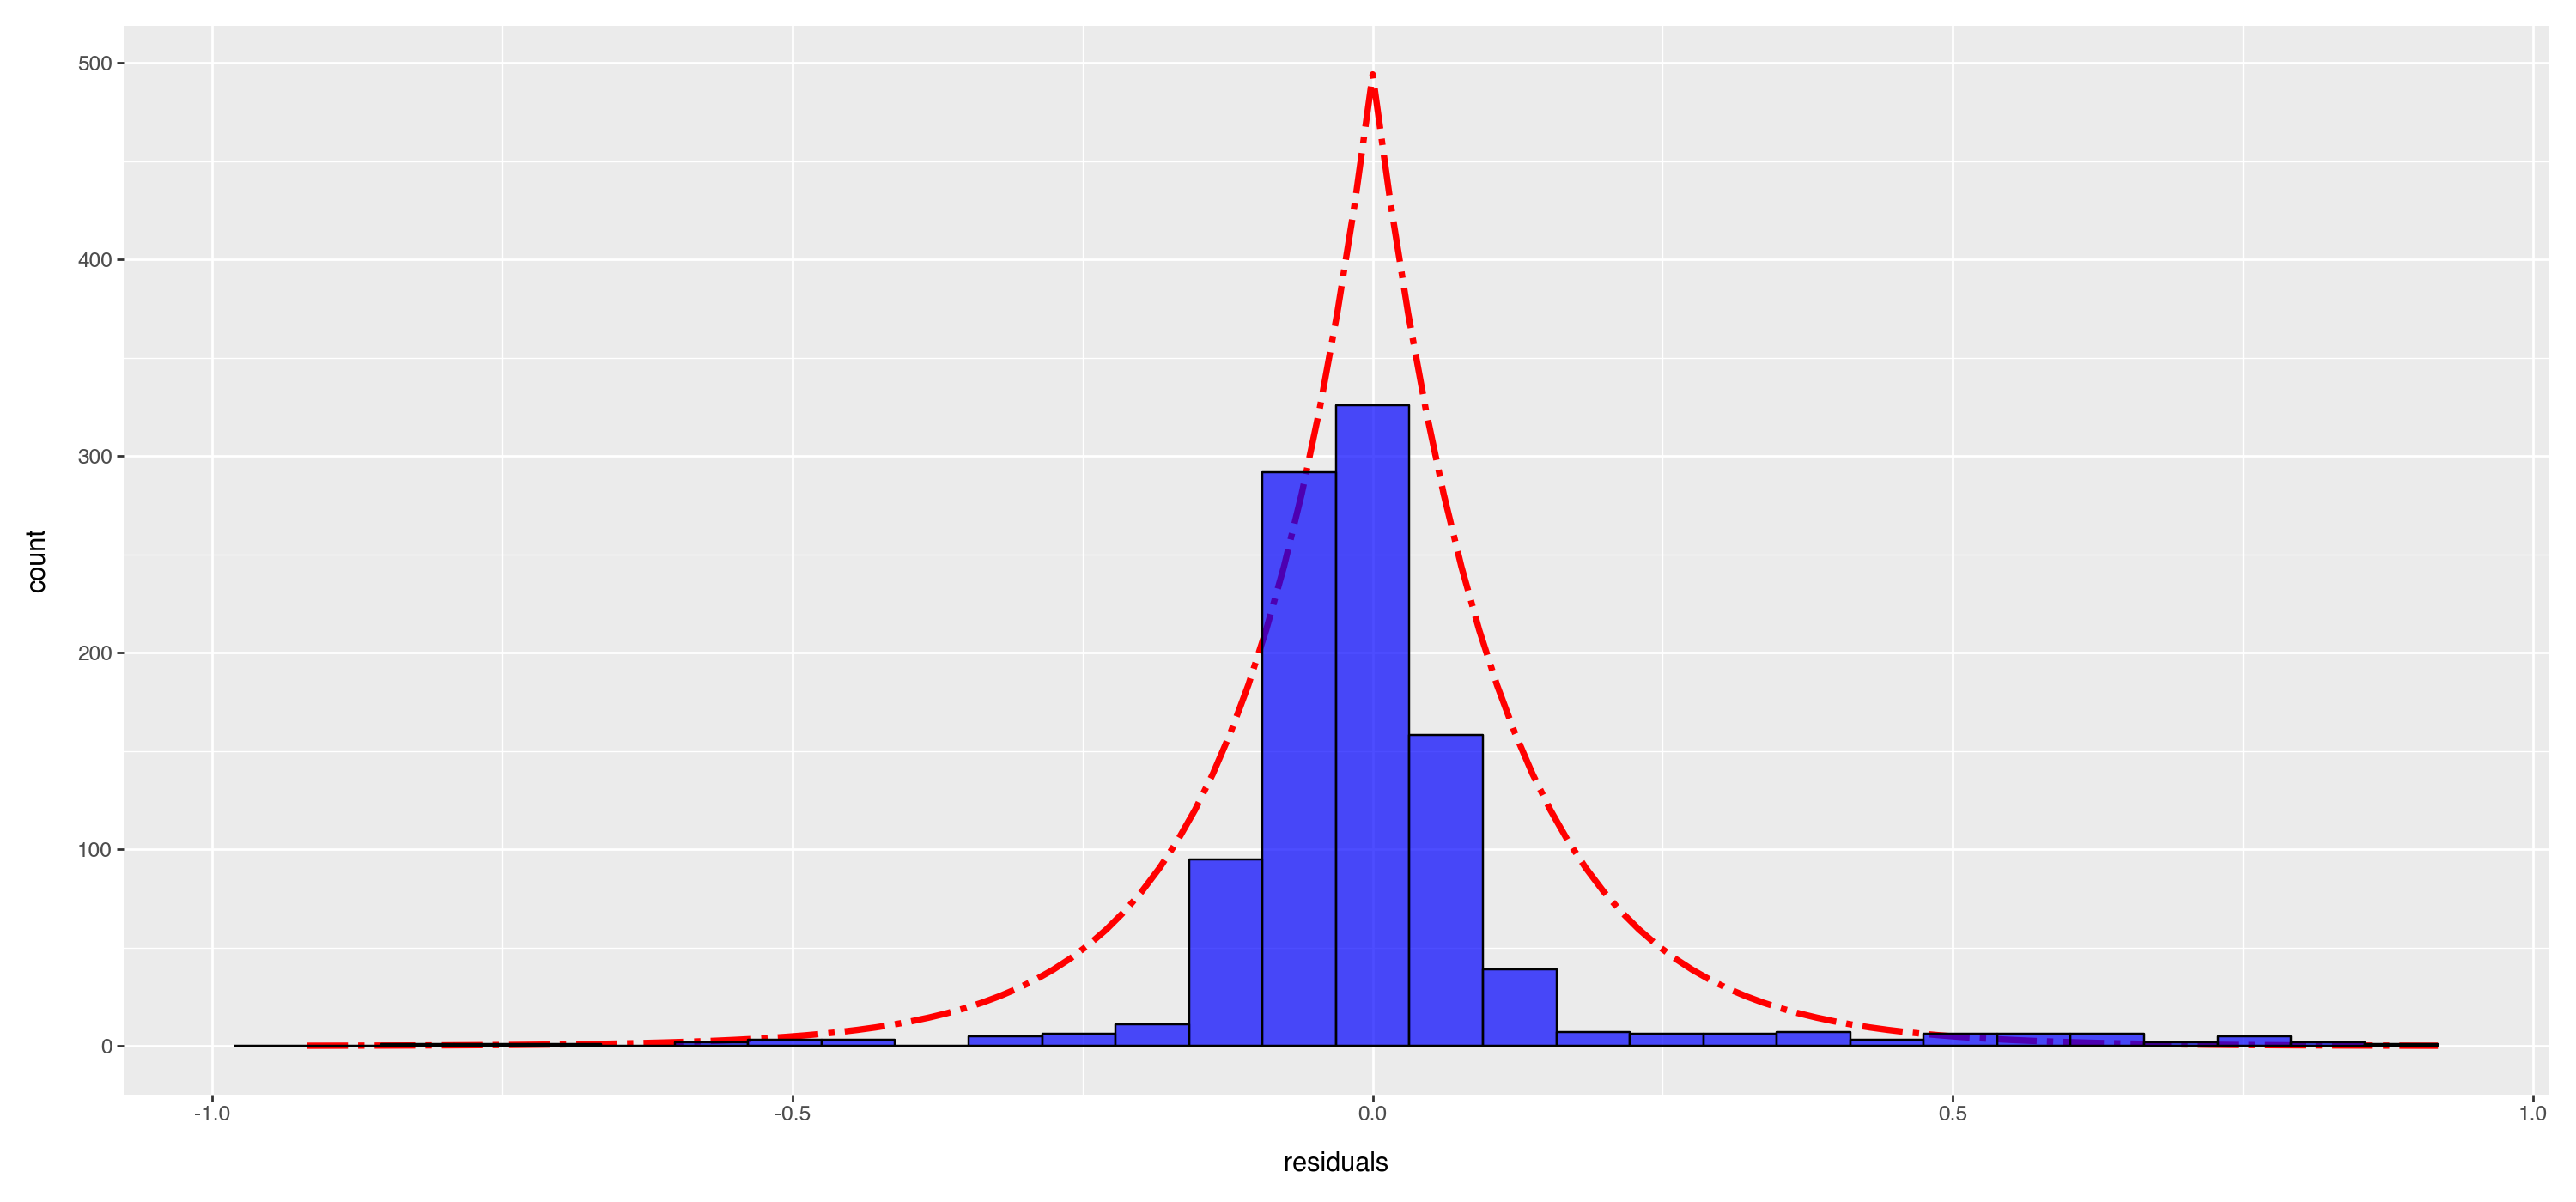

In [279]:
ndf = DataFrame({'x': arange(-6*sigma, 6*sigma, sigma/10)})
# use moment matching to find good parameters for Laplace distribution
ndf['p'] = laplace.pdf(ndf['x'], loc=mu, scale=1/np.sqrt(2)*sigma) 
ndf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7 # Use tambov constant to align graphs

p = ggplot(residuals) 
p += geom_line(aes(x='x', y='h'), data=ndf, color='red', size=1.5, linetype='dashdot')
p += geom_histogram(aes(x='residuals'), bins=30, fill="blue", color="black", alpha=0.7)
p += labs(x="residuals", y='count')
display(p)
#p.save('naive_fit_residuals_laplace.pdf', path='results', height=6, width=12, verbose=False)

**Coclusion:** Laplace distribution is not a better fit. However, we have not computed coefficients based on additive Laplace error assumption. Hoever, we can already see that large residuals get larger probability assignments and thus have less influence on the coefficients if we pursue maximum likelihood fit. 

## II. Correct minimisation goal for additive Laplacian noise

Again we can use Maximum Likelihood principle and find parameter values for $\alpha,\beta\in\mathbb{R}$ that maximise the probability of observations. For brevity let us denote all model parameters by $\Theta$. Then we can express

\begin{align*}
p[x_1,\ldots,x_n, y_1,\ldots, y_n|\Theta]=p[x_1,\ldots,x_n]\cdot p[y_1,\ldots, y_n|x_1,\ldots,x_n,\Theta]\propto p[y_1,\ldots, y_n|x_1,\ldots,x_n,\Theta]\enspace.
\end{align*}
Let $y_i=\alpha x_i + \beta + \varepsilon_i$ for independently chosen $\varepsilon_i\sim\mathcal{L}(0,\sigma)$. Then clearly
\begin{align*}
p[x_1,\ldots,x_n, y_1,\ldots, y_n|\Theta]\propto\prod_{i=1}^n p[y_i|x_i\Theta] 
\end{align*}
where
\begin{align*}
p[y_i|x_i\Theta]=p[\varepsilon_i=y_i-\alpha x_i-\beta|\varepsilon_i\sim\mathcal{L}(0,\sigma)] \enspace.
\end{align*}

By substituting the density function of Laplace distribution into the equation we get
\begin{align*}
p[y_i|x_i\Theta]=\frac{1}{2\sigma}\cdot\exp\left(-\frac{|y_i-\alpha x_i-\beta|}{\sigma}\right).
\end{align*}

Thus the log-likelihood of the data can be expressed as
\begin{align*}
\ell[x_1,\ldots,x_n, y_1,\ldots, y_n|\Theta]=\mathrm{const}-n\log \sigma-\sum_{i=1}^n \frac{|y_i-\alpha x_i-\beta|}{\sigma}
\end{align*}

For a moment let us fix $\sigma>0$ and maximise the log likelihood expression. Then we clearly need to minimise
\begin{align*}
F(\alpha,\beta)=\sum_{i=1}^n |y_i-\alpha x_i-\beta|
\end{align*}

As the optimal solution for $\alpha, \beta$ is the same for all parameter $\sigma$ values, we can find $\sigma$ value separately after fitting $\alpha$ and $\beta$. Let $r_i=y_i-\hat{y}_i$ denote residuals for predictions $\hat{y}_i=\alpha x_i+\beta$. Then we need to minimise

\begin{align*}
G(\sigma)=n\log \sigma +\sum_{i=1}^n \frac{|r_i|}{\sigma}
\end{align*}

The corresponding equation for derivative 
\begin{align*}
\frac{\partial G}{\partial \sigma}=\frac{n}{\sigma} -\frac{1}{\sigma^2}\cdot \sum_{i=1}^n |r_i|=0
\end{align*}
implies 
\begin{align*}
\sigma =\frac{1}{n}\cdot \sum_{i=1}^n |r_i|\enspace.
\end{align*}




## III. Direct implementation of Least Absolute Deviations regression

Linear regression can be defined by using a single neuron with linear activation function.
To make the transformation $z=x^2$ explicit we define a separate feature layer using `Lambda` layer.
To get desired fit we need to fix Mean Absolute Error as the final loss.

For comparison, we also define network with Mean Square Error as the final loss.
To make training runs comparable we start gradient decent from the point $\alpha=0$ and $\beta=0$.
This a valid search strategy for linear regression as there is a single global minimum.

In [409]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential

from tensorflow.keras.initializers import Zeros
from tensorflow.keras.optimizers import Adam

mse_model = Sequential([
    Input(shape=(1,)),
    Lambda(lambda x: x**2),    
    Dense(1, activation='linear', 
          kernel_initializer=Zeros(), bias_initializer=Zeros()) 
])
mse_model.compile(optimizer=Adam(learning_rate=0.005), loss='mse', metrics=['mse', 'mae'])

mae_model = Sequential([
    Input(shape=(1,)),
    Lambda(lambda x: x**2),    
    Dense(1, activation='linear', 
          kernel_initializer=Zeros(), bias_initializer=Zeros()) 
])
mae_model.compile(optimizer=Adam(learning_rate=0.005), loss='mae', metrics=['mse', 'mae'])


### Advanced telemery during training

For visualisation purposes, it is nice to see how model parameters change during gradient search for different regression algorithms.
For that we need to extract coefficients from the second layer. The corresponding reshaping is slightly cumbersome as weights are double packed while bias terms are packed only once

In [282]:
mae_model.layers[1].get_weights()

[array([[0.]], dtype=float32), array([0.], dtype=float32)]

In [283]:
from tensorflow.keras.callbacks import Callback

In [410]:
class ParameterTracker(Callback):
    def __init__(self, verbose=1):
        self.weights_history = []   
        self.biases_history = []   
        self.verbose = verbose
        
    def on_train_begin(self, logs=None):
        # Access the initial values of Dense layer
        weights, biases = self.model.layers[1].get_weights()
        
        # Unpack and store the weights and biases for each epoch
        self.weights_history = [weights[0][0]]  
        self.biases_history = [biases[0]]        

        if self.verbose != 0:
            display(Math(rf"\text{{Epoch }} {0}\text{{: }} \alpha = {weights[0][0]:1.8f}, \beta = {biases[0]:1.8f}"))

    def on_epoch_end(self, epoch, logs=None):
        # Access the Dense layer
        weights, biases = self.model.layers[1].get_weights()
        
        # Unpack and store the weights and biases for each epoch
        self.weights_history.append(weights[0][0])  
        self.biases_history.append(biases[0])

        if self.verbose != 0:
            display(Math(rf"\text{{Epoch }} {epoch + 1}\text{{: }} \alpha = {weights[0][0]:1.8f}, \beta = {biases[0]:1.8f}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

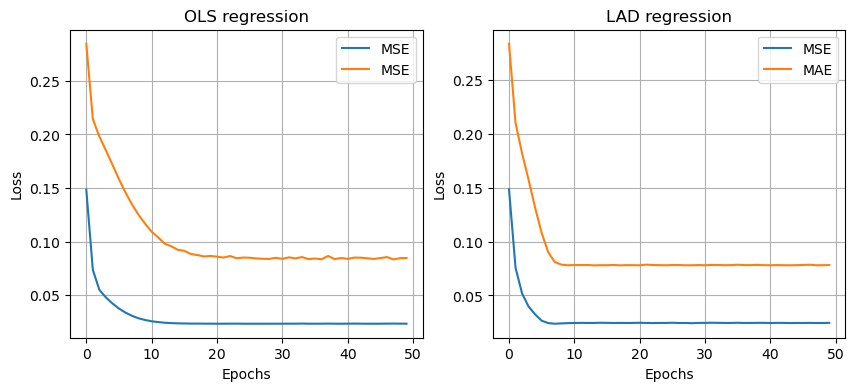

In [411]:
epochs = 50
mse_tracker = ParameterTracker(verbose=0)
mse_history = mse_model.fit(df['$x^1$'], df['$y$'], epochs=epochs, batch_size=32, callbacks=[mse_tracker], verbose=0)

alpha, beta = mse_model.layers[1].get_weights()
display(Math(rf'\text{{OLS regression result }}{alpha[0][0]:1.4f} \times x^2 +{beta[0]:1.4f}'))

mae_tracker = ParameterTracker(verbose=0)
mae_history = mae_model.fit(df['$x^1$'], df['$y$'], epochs=epochs, batch_size=32, callbacks=[mae_tracker], verbose=0)

alpha, beta = mae_model.layers[1].get_weights()
display(Math(rf'\text{{LAD regression result }}{alpha[0][0]:1.4f} \times x^2 +{beta[0]:1.4f}'))


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(mse_history.history['mse'], label='MSE')
axes[0].plot(mse_history.history['mae'], label='MSE')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('OLS regression')
axes[0].legend(loc="upper right")
axes[0].grid(True)

axes[1].plot(mae_history.history['mse'], label='MSE')
axes[1].plot(mae_history.history['mae'], label='MAE')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('LAD regression')
axes[1].legend(loc="upper right")
axes[1].grid(True)

plt.show()

### Visualisation of OLS and LAD model fits

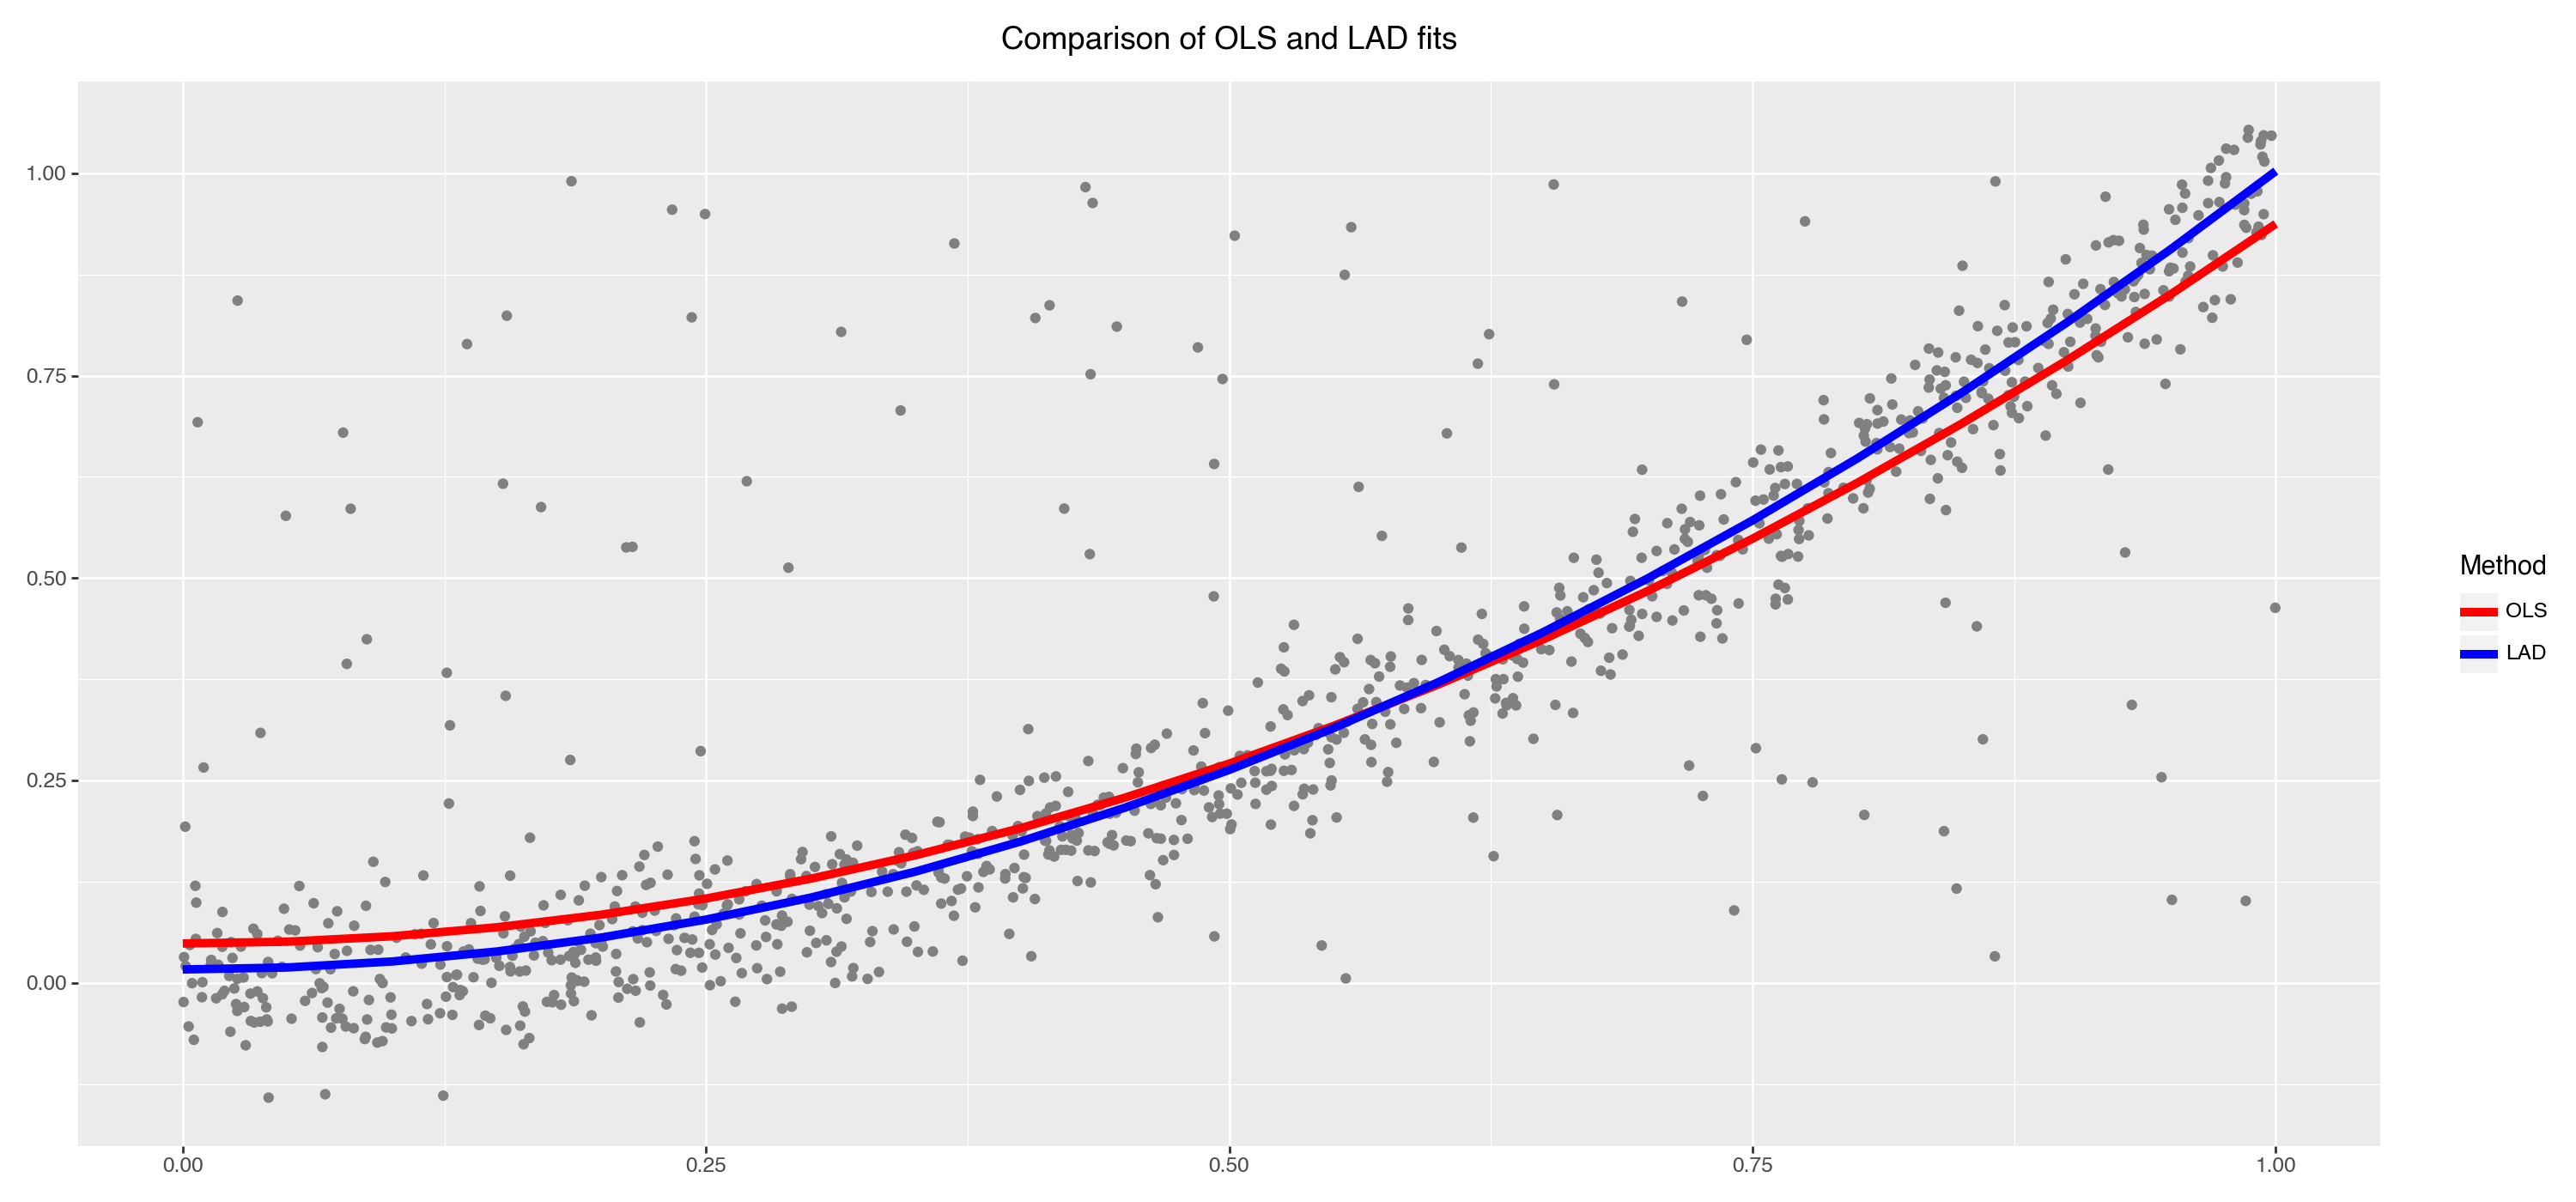

In [412]:
# Compute prediction line
dmse = DataFrame({'x':arange(0, 1.05, 0.05)})
dmse['y'] = mse_model.predict(dm['x'], verbose=0)

dmae = DataFrame({'x':arange(0, 1.05, 0.05)})
dmae['y'] = mae_model.predict(dm['x'], verbose=0)

# Show the corresponding graph 
p  = ggplot(df) 
p += geom_point(aes(x='$x^1$', y='$y$'), color='grey')
p += xlab('') 
p += ylab('') 
p += geom_line(aes(x='x', y='y', color='tmp'), data=dmse.assign(tmp=pd.Categorical(['OLS']*len(dmse), categories=['OLS', 'LAD'])), size=2)
p += geom_line(aes(x='x', y='y', color='tmp'), data=dmae.assign(tmp=pd.Categorical(['LAD']*len(dmse), categories=['OLS', 'LAD'])), size=2)
p += ggtitle('Comparison of OLS and LAD fits')
p += labs(x="", y='')
p += scale_color_manual(name = 'Method' ,breaks=['OLS', 'LAD'], values=['red', 'blue'])
display(p)

**Judgement:** The LAD fit follows the main mass of data significantly better than OLS fit.

### Visualisation of gradient search paths

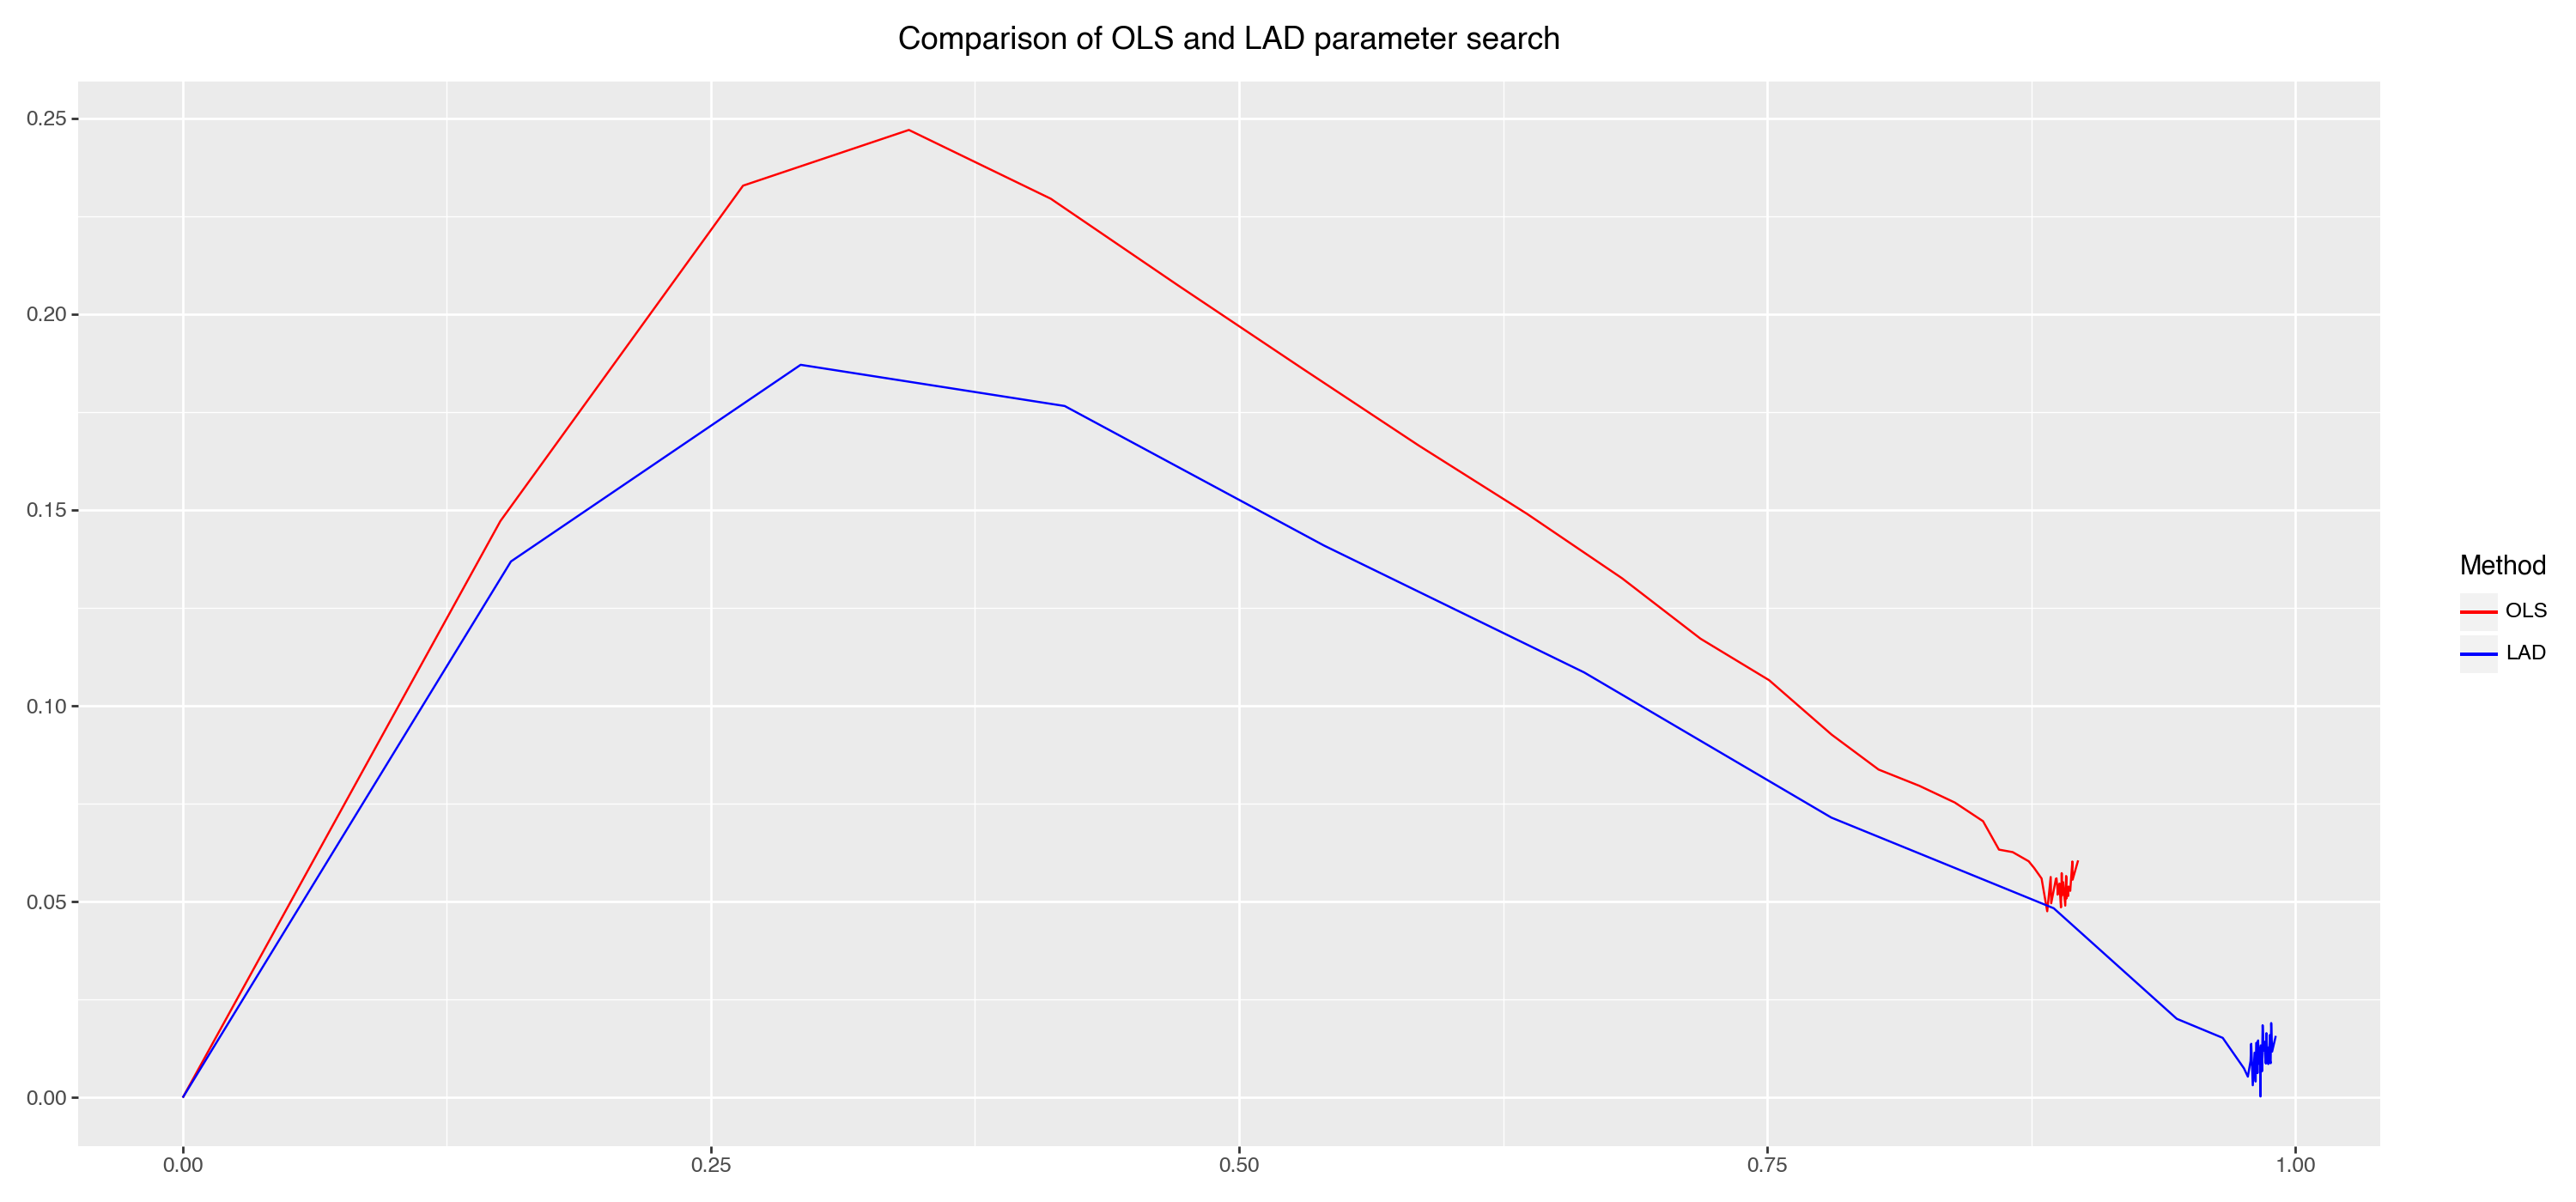

In [427]:
dpf = DataFrame({
    'epoch': range(epochs + 1),
    'mse_alpha': mse_tracker.weights_history,
    'mse_beta': mse_tracker.biases_history,
    'mae_alpha': mae_tracker.weights_history,
    'mae_beta': mae_tracker.biases_history,
    'mse': pd.Categorical(['OLS'] * (epochs + 1), categories=['OLS', 'LAD']), 
    'mae': pd.Categorical(['LAD'] * (epochs + 1), categories=['OLS', 'LAD']) 
})

p = ggplot(dpf) + xlab(r'$\alpha$') + ylab(r'$\beta$') 
p += geom_line(aes(x='mse_alpha', y='mse_beta', color='mse')) 
p += geom_line(aes(x='mae_alpha', y='mae_beta', color='mae')) 
p += ggtitle('Comparison of OLS and LAD parameter search')
p += labs(x="", y='')
p += scale_color_manual(name = 'Method' ,breaks=['OLS', 'LAD'], values=['red', 'blue'])
display(p)

**Judgement:** Both methods oscilate in final epochs -- learning rate is too big in these steps. 

### Visualisation of residual fits

In [454]:
ypred = mae_model.predict(df['$x^1$'], verbose=0).flatten()
residuals = DataFrame({'residuals': df['$y$'] - ypred, 'method': 'LAD'})
sigma_mae = residuals['residuals'].std()

ypred = mse_model.predict(df['$x^1$'], verbose=0).flatten()
residuals = pd.concat([residuals, DataFrame({'residuals': df['$y$'] - ypred, 'method': 'OLS'})], ignore_index=True)
sigma_mse = residuals['residuals'].std()

In [453]:
residuals

,residuals,method
0,-0.026742,LAD
1,-0.012798,LAD
2,0.091113,LAD
3,0.077331,LAD
4,-0.246934,LAD
...,...,...
1995,-0.043230,OLS
1996,-0.056247,OLS
1997,-0.017521,OLS
1998,-0.016821,OLS


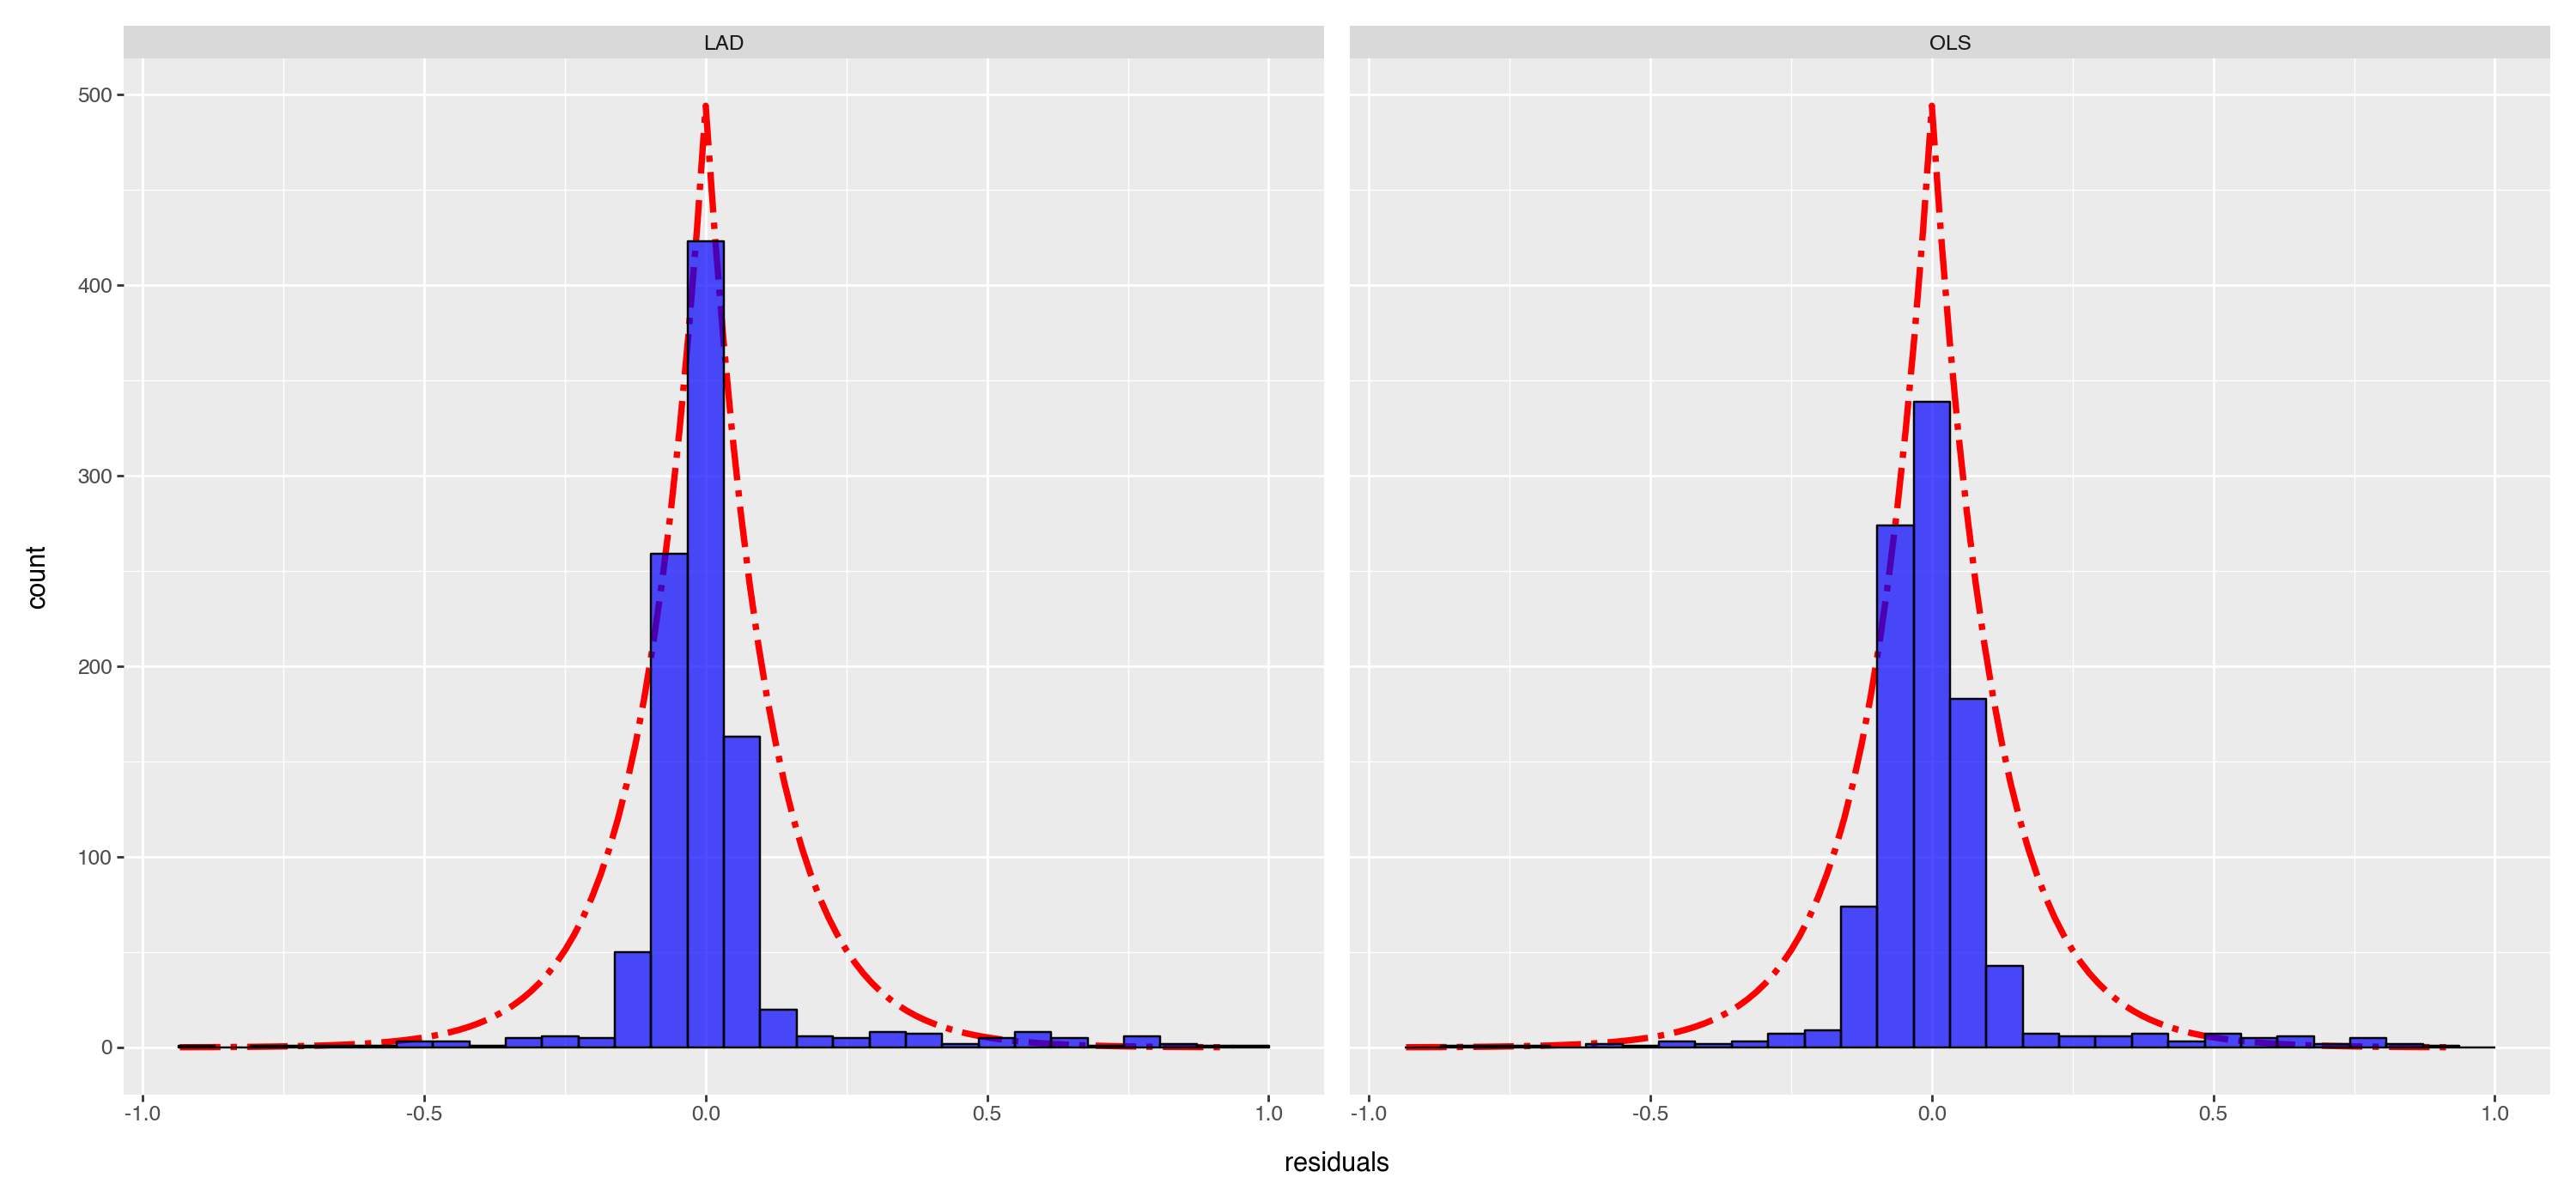

In [460]:
odf = DataFrame({'x': arange(-6*sigma, 6*sigma, sigma/10)})
# use moment matching to find good parameters for Laplace distribution
odf['p'] = norm.pdf(ndf['x'], loc=mu, scale=1/np.sqrt(2)*sigma_mse) 
odf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7 # Use tambov constant to align graphs
odf['method'] = 'OLS'

ldf = DataFrame({'x': arange(-6*sigma, 6*sigma, sigma/10)})
# use moment matching to find good parameters for Laplace distribution
ldf['p'] = laplace.pdf(ndf['x'], loc=mu, scale=1/np.sqrt(2)*sigma_mae) 
ldf['h'] = ndf['p'] * len(df)/ndf['p'].sum()*7 # Use tambov constant to align graphs
ldf['method'] = 'LAD'

p = ggplot(residuals) 
p += geom_line(aes(x='x', y='h'), data=odf, color='red', size=1.5, linetype='dashdot')
p += geom_line(aes(x='x', y='h'), data=ldf, color='red', size=1.5, linetype='dashdot')
p += geom_histogram(aes(x='residuals'), bins=30, fill="blue", color="black", alpha=0.7)
p += facet_wrap('method')
p += labs(x="residuals", y='count')
display(p)

**Judgement:** Residual matching is better for LAD model but residuals clearly do mot follow Laplace distribution. 

## IV. Ridge and LASSO regression methods 

To be completed

# Homeworks

## 7.1 Histogram matching$^*$ (<font color='red'>1p</font>)

In the graphs above use used hand-tuned scaling factor to align density function with histograms. This is not a good practise. Derive a formula for scaling the density function given that all bins in the histogram have equal lengths. For that compute what is the expected number of observations for each bin and choose the scaling factor so that area under each bin is equal to the expected number of observations. Implement the corresponding algorithm and redraw LAD vs OLS histograms.  Test correctness of your scaling using simulation to be sure.

## 7.2 Comparison of Ridge and LASSO regression algorithms

TBA:
* Graph how coefficients change with different penalties. Use heatmap for visualisation. Skatterplot is alternative 


## 7.3 Leverage of different points

TBA
* Naive implementation with pertubations
* Gradient tape interpretation